In [27]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import math

import utils
import train_infer_utils
from model import UNet
from config import Config
from consts import Consts

In [28]:
trans = transforms.ToTensor()
reverse_trans = transforms.ToPILImage()
train_set = datasets.MNIST(
    "data", train=True, download=True, transform=trans
)
test_set = datasets.MNIST(
    "data", train=False, download=True, transform=trans
)

In [29]:
train_loader = DataLoader(
    train_set, batch_size=Config.batch_size, shuffle=True, num_workers=4, drop_last=True
)

test_loader = DataLoader(
    test_set, batch_size=Config.batch_size, shuffle=True, num_workers=4, drop_last=True
)

print(len(train_set))

60000


torch.Size([64, 1, 28, 28])
(28, 28)


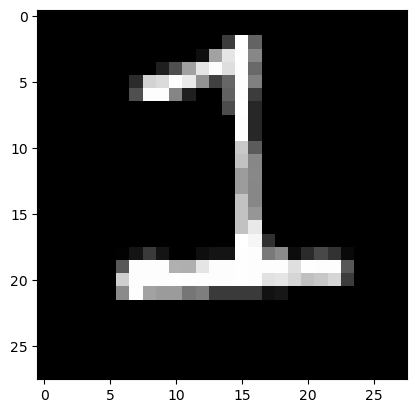

In [30]:
for (X, y) in train_loader:
    print(X.size())
    X = X[0]

    img = reverse_trans(X)
    print(img.size)
    plt.imshow(img, cmap='gray')
    break

In [31]:
for (X, y) in train_loader:
    X = X[0]
    print(X.shape)
    imgs = [train_infer_utils.get_noisy_image(X, torch.tensor([t])) for t in [0, 50, 100, 150, 199]]
    imgs = list(map(lambda img : reverse_trans(img), imgs))
    print(imgs[0].size)
    utils.plot(imgs, cmap ='gray')
    break

torch.Size([1, 28, 28])
(28, 28)


In [32]:
model = UNet(Config.channels, Config.channels, Config.time_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=Config.lr)
device = "cuda" if torch.cuda.is_available() else "cpu"

model.to(device)

UNet(
  (time_embedding): TimeEmbedding(
    (time_embedding): Sequential(
      (0): Linear(in_features=28, out_features=112, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=112, out_features=112, bias=True)
    )
  )
  (in_conv): InConv(
    (in_conv): ResidualDoubleConvBlock(
      (conv1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (conv2): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
      )
      (mlp): Sequential(
        (0): SiLU()
        (1): Linear(in_features=112, out_features=64, bias=True)
      )
      (res

In [33]:
sum_img = 0
torch.autograd.set_detect_anomaly(True)
for epoch in range(Config.epochs):
    for (X, y) in train_loader:
        optimizer.zero_grad()
        X = X.to(device)

        step = torch.randint(0, Config.timesteps, (Config.batch_size,), device=device)
        loss = train_infer_utils.diff_loss(X, step, model)

        loss.backward()
        optimizer.step()

        sum_img += Config.batch_size
        print(f"{sum_img : 7d} : {loss.item() * 100 : .3f}%")
        # if sum_img >= 100000:
        #     break

     64 :  45.790%
    128 :  17.842%
    192 :  22.173%
    256 :  14.347%
    320 :  10.173%
    384 :  10.250%
    448 :  8.545%
    512 :  7.291%
    576 :  6.719%
    640 :  6.788%
    704 :  8.206%
    768 :  6.671%
    832 :  7.789%
    896 :  7.344%
    960 :  6.942%
   1024 :  6.055%
   1088 :  6.200%
   1152 :  5.968%
   1216 :  8.025%
   1280 :  6.127%
   1344 :  6.254%
   1408 :  6.646%
   1472 :  5.368%
   1536 :  5.397%
   1600 :  5.798%
   1664 :  6.409%
   1728 :  5.127%
   1792 :  5.776%
   1856 :  5.683%
   1920 :  5.019%
   1984 :  5.283%
   2048 :  5.631%
   2112 :  6.702%
   2176 :  5.470%
   2240 :  4.700%
   2304 :  4.716%
   2368 :  5.807%
   2432 :  5.749%
   2496 :  4.488%
   2560 :  4.829%
   2624 :  5.369%
   2688 :  5.220%
   2752 :  5.885%
   2816 :  4.953%
   2880 :  5.379%
   2944 :  4.942%
   3008 :  5.130%
   3072 :  7.243%
   3136 :  4.134%
   3200 :  4.508%
   3264 :  3.859%
   3328 :  4.571%
   3392 :  5.399%
   3456 :  4.444%
   3520 :  4.969%
   3

In [34]:
torch.save(model.state_dict(), Config.model_path)